# Dependencies

In [1]:
import sys
print(sys.version)


3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]


In [2]:
#import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#import tensorflow dependencies - Functional API components
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Flatten,Dense,Input,MaxPooling2D

In [4]:
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("Available GPU devices:")
    for gpu in gpu_devices:
        print(gpu)
else:
    print("No GPU devices found")


No GPU devices found


# Set GPU Growth

In [5]:
#Avoid OOM errors by settings GPU Memory Consumption Growth
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [6]:
len(gpus)

0

# Checking the CUDA Installation

In [11]:
!pip install tensorflow-gpu


ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu


# Create Folder Structures

In [7]:
#defining the paths or selecting them
POS_PATH=os.path.join('data','positive')
NEG_PATH=os.path.join('data','negative')
ANC_PATH=os.path.join('data','anchor')

In [55]:
#Make Directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# Collect the positives and anchors


In [8]:
#Mov lfw images to the following repository  data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH=os.path.join('lfw',directory,file);
        NEW_PATH=os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

# Collect Positive and Anchor Classes

In [9]:
import uuid

In [10]:
#Establish a connection with the webcam
cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()
    
    #cut down the frame to 250x250
    frame=frame[120:120+250,200:200+250, :]
    
#Show image back to screen
    cv2.imshow('Image being captured',frame)
    
#Collecting the positives
    if cv2.waitKey(1) & 0XFF==ord('p'):
        #Creating a unique file path 
        imgname=os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        #Write out positives image
        cv2.imwrite(imgname,frame)
    
#Collecting the anchors
    if cv2.waitKey(1) & 0XFF==ord('a'):
        #Creating a unique file path 
        imgname=os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        #Write out anchor image
        cv2.imwrite(imgname,frame)
    
    
#Breaking gracefully
    if cv2.waitKey(1) & 0XFF==ord('q'):
          break                 

#Release the webcam            
cap.release()
#Close Image Show frame
cv2.destroyAllWindows()

# Load and Preprocess the Images

## 3.1 Get Image Directories


In [22]:
anchor=tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(200) # check what the performance suits like to the model 
positive=tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(200)#takes the path of the dataset in POS_PATH directory and total count = 300
negative=tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(200)

In [23]:
dir_test=anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\1f5ff3c2-f755-11ee-a103-6479f0d51122.jpg'


## 3.3Preprocessing Scale and Resize 

In [24]:
def preprocess(filepath):
    #Reads in the image from file path
    byte_img=tf.io.read_file(filepath)
    #laads the image
    img=tf.io.decode_jpeg(byte_img)
    #Preprocessing step- resizing the image in to 100x100x3
    img=tf.image.resize(img,(105,105))
    #Scale an image between 0 and 1 
    img=img/255.0
    return img

In [25]:
imager=preprocess('data\\anchor\\365f301d-f755-11ee-bdaf-6479f0d51122.jpg')

In [26]:
imager.numpy().max()

1.0

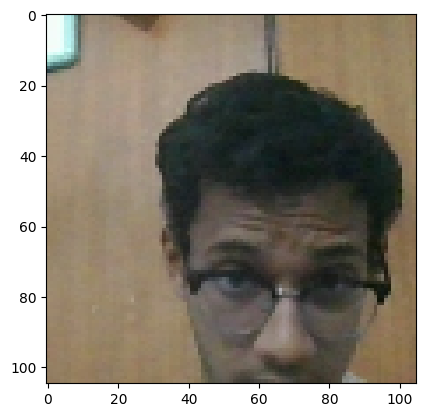

In [27]:
plt.imshow(imager)

## 3.4 Create a labelled Dataset

In [28]:
#anchors,positive=1,1,1,1,1
#anchors,negative=0,0,0,0,0

In [29]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
#This line combines the anchor, positive, and a dataset of ones into a single dataset using tf.data.Dataset.zip(). The ones are likely labels indicating positive examples. It's setting up the data in a format where each sample consists of an anchor image path, a positive image path, and the label (in this case, 1 for positive).
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))) # creates a seperate dataset for 0s
data=positives.concatenate(negatives)

In [30]:
samples=data.as_numpy_iterator()
examples=samples.next()

In [31]:
examples

(b'data\\anchor\\00b5ca02-f7cb-11ee-8191-6479f0d51122.jpg',
 b'data\\positive\\e8969c9b-f7cf-11ee-8816-6479f0d51122.jpg',
 1.0)

## 3.5 Build Train and Test Partitions

In [32]:
def preprocess_twin(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label)

In [33]:
res=preprocess_twin(*examples) # *examples unpacks what is there in the examples variable

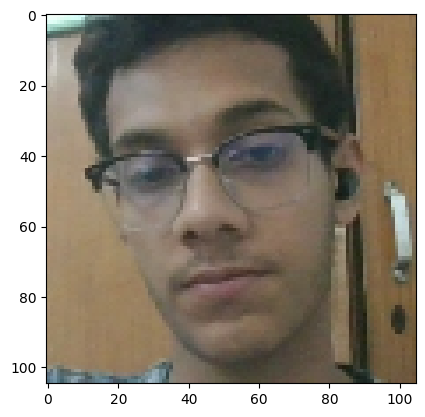

In [34]:
plt.imshow(res[1])

In [35]:
res[2]

1.0

In [36]:
#Build dataloader pipeline
data=data.map(preprocess_twin)
data=data.cache() #cachine for speed retrieval of the dataset, especially during large dataset
data=data.shuffle(buffer_size=1024)

In [37]:
#training partition
train_data=data.take(round(len(data)*.7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)
#The 8 specifies the number of batches to prefetch. So, while the
#model is processing one batch of data (which takes some time, especially on GPUs), 
#the data pipeline is already preparing the next 8 batches in the background. 

In [38]:
train_samples=train_data.as_numpy_iterator()

In [39]:
train_sample=train_samples.next()

In [40]:
#testing partition
test_data=data.skip(round(len(data)*.7))
test_data=test_data.take(round(len(data)*.3))
test_data=test_data.batch(16) 

# Model Engineering

## 1.Build Embedding Layer

## Testing and getting to know about layers 

In [41]:
inp=Input(shape=(105,105,3),name='input_image')
inp #Maybe you can change to 100,100,3 later for the model testing

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [42]:
c1=Conv2D(64,(10,10),activation='relu')(inp)
print(c1)
m1=MaxPooling2D(64,(2,2),padding='same')(c1)
print(m1)


KerasTensor(type_spec=TensorSpec(shape=(None, 96, 96, 64), dtype=tf.float32, name=None), name='conv2d/Relu:0', description="created by layer 'conv2d'")
KerasTensor(type_spec=TensorSpec(shape=(None, 48, 48, 64), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")


In [43]:

    #Second block
    c2=Conv2D(128,(7,7),activation='relu')(m1)
    print(c2)
    m2=MaxPooling2D(64,(2,2),padding='same')(c2)
    print(m2)
    

KerasTensor(type_spec=TensorSpec(shape=(None, 42, 42, 128), dtype=tf.float32, name=None), name='conv2d_1/Relu:0', description="created by layer 'conv2d_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 21, 21, 128), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")


In [44]:
    #Third block
    c3=Conv2D(128,(4,4),activation='relu')(m2)
    print(c3)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)
    print(m3)

KerasTensor(type_spec=TensorSpec(shape=(None, 18, 18, 128), dtype=tf.float32, name=None), name='conv2d_2/Relu:0', description="created by layer 'conv2d_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9, 9, 128), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")


In [45]:
     #Final Embedding Block
c4=Conv2D(256,(4,4),activation='relu')(m3)
print(c4)
f1=Flatten()(c4)
print(f1)
d1=Dense(4096,activation='sigmoid')(f1)
print(d1)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 256), dtype=tf.float32, name=None), name='conv2d_3/Relu:0', description="created by layer 'conv2d_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9216), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4096), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")


In [46]:
mod=Model(inputs=[inp],outputs=[d1],name='embedder')
mod.summary()

Model: "embedder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       262

In [47]:
def make_embedding():
    inp=Input(shape=(105,105,3),name='input_image')
    
    #First block
    c1=Conv2D(64,(10,10),activation='relu')(inp)
    m1=MaxPooling2D(64,(2,2),padding='same')(c1)
    
    
    #Second block
    c2=Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPooling2D(64,(2,2),padding='same')(c2)
    
    #Third block
    c3=Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)
    
    #Final Embedding Block
    c4=Conv2D(256,(4,4),activation='relu')(m3)
    f1=Flatten()(c4)
    d1=Dense(4096,activation='sigmoid')(f1)
    
    # I want the input layer to have 100x100 pixels and 3 channels
    return Model(inputs=[inp],outputs=[d1],name='embedding')

In [48]:
embedding=make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 18, 128)       26

## 2.Build Distance Layer 

In [49]:
#Siamese L1 Distance class
class L1Dist(Layer):
    #Init method-inheritance
    def __init__(self,**kwargs):
        super().__init__();
        
    #Magic happens here- similarity calculation
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

In [50]:
input_image=Input(name="input_img",shape=(105,105,3))
validation_image=Input(name="validation_img",shape=(105,105,3))


In [51]:
inp_embedding=embedding(input_image)
val_embedding=embedding(validation_image)

In [52]:
siamese_layer=L1Dist()
siamese_layer(inp_embedding,val_embedding)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist')>

## 3.Make Siamese Model

In [53]:
def make_siamese_model():
    #Handle Inputs
    
    #Anchor image input in the network
    input_image=Input(name="input_img",shape=(105,105,3))
    
    #Validation image in the network
    validation_image=Input(name="validation_img",shape=(105,105,3))
    
    #Combine the Siamese Distance components
    siamese_layer=L1Dist()
    siamese_layer._name="distance"
    distances=siamese_layer(embedding(input_image),embedding(validation_image))
    
    #Classification Layer
    classifier=Dense(1,activation='sigmoid')(distances)
    
    return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')

In [54]:
siamese_network=make_siamese_model()
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

## 1. Setup Loss and Optimizer

In [55]:
binary_cross_entropy=tf.losses.BinaryCrossentropy()

In [56]:
op=tf.keras.optimizers.Adam(1e-4)#0.0001

## 2. Establish Checkpoints

In [57]:
checkpoints_dir='./training_checkpoints'
checkpoints_prefix=os.path.join(checkpoints_dir,'ckpt')
checkpoint=tf.train.Checkpoint(op=op,siamese_network=siamese_network) # allows to save and restore the state of model during training and inference

## 3. Build Train Step Function

In [58]:
tester=train_data.as_numpy_iterator()
batch_1=tester.next()
X=batch_1[:2]
Y=batch_1[2]


In [59]:
Y

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [60]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
       #Get anchor and positive/negative image
        X=batch[:2]
        #Get Label
        Y=batch[2]
        
        #Forward pass
        yhat=siamese_network(X,training=True)
        #Calculate the loss
        loss=binary_cross_entropy(Y,yhat)
    print(loss)    
        
    #Calculate gradient
    grad=tape.gradient(loss,siamese_network.trainable_variables)
    
    #Calculate the updated weights and apply to siamese model
    op.apply_gradients(zip(grad,siamese_network.trainable_variables))
        
    #return loss    
    return loss

## 4. Build a Training Loop

In [61]:
def train(data,EPOCHS):
    # Loop through the EPOCHS
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar=tf.keras.utils.Progbar(len(data))
    
        # Loop through each batch
        for idx, batch in enumerate(data):
            #Run train step here
            train_step(batch)
            progbar.update(idx+1)
            
        #Save checkpoints 
        if epoch%10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    

## Train the model 

In [62]:
EPOCHS=5

In [51]:
print('GPU available',tf.config.list_physical_devices('GPU'))

GPU available []


# Evaluate Model

In [63]:
#Import metric calculation
from tensorflow.keras.metrics  import Precision, Recall

In [64]:
#Get a batch of test data
test_input, test_val, y_true=test_data.as_numpy_iterator().next()

In [65]:
test_var=test_data.as_numpy_iterator().next()

In [66]:
print(tf.test.is_built_with_cuda())

True


# Save Model

In [67]:
model=tf.keras.models.load_model('siamesemodel.h5',custom_objects={'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

# Real Time Test

## Verification Function

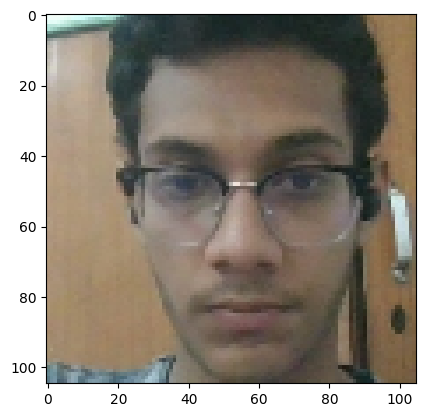

In [69]:
for image in os.listdir(os.path.join('application_data','verification_images')):
        validation_img=preprocess(os.path.join('application_data','verification_images',image))
        plt.imshow(validation_img)

In [70]:
def verify(model, detection_threshold, verification_threshold):
    #Build results array
    results=[]
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img=preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img=preprocess(os.path.join('application_data','verification_images',image))
        #Make prediction
        result=model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        results.append(result)

#Detection threshold:Metric above which a prediction is considered positive        
    detection=np.sum(np.array(results)>detection_threshold)
#Verification threshold: proportion of positive prediction / total positive samples
    verification=detection/len(os.listdir(os.path.join('application_data','verification_images')))
    verified=verification>verification_threshold
    
    return results,verified
    


## OpenCV Real time Verification

In [131]:
cap =cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame=cap.read()
    
    #cut down the frame to 250x250
    frame=frame[120:120+250,200:200+250, :]
    cv2.imshow('Verification',frame)
    
    
    #verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #Save input image to input image folder
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'),frame)
#   Run verification
        results,verified=verify(model,0.9,0.71)
        print(verified)
        


    if cv2.waitKey(10) & 0xFF == ord('q'):
        break;

        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 225ms/step
True
1/1 [==============================] - 0s 241ms/step
False


TypeError: 'NoneType' object is not subscriptable

In [129]:
np.sum(np.squeeze(results)>0.9)

37

In [130]:
37/50


0.74

In [ ]:
tilak=31,0.62
shreyansh=39,0.78

In [60]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][